#Supervised Learning (Classification)#
##PIRvision_FoG_presence_detection##
The PIRvision dataset contains occupancy detection data collected from a Synchronized Low-Energy
Electronically-chopped Passive Infra-Red sensing node in residential and office environments. Each
observation represents 4 seconds of recorded human activity within the sensor Field-of-View (FoV).
Dataset Characteristics
Tabular, Sequential, Multivariate, Time-Series, Text
Subject Area
Climate and Environment
Associated Tasks
Classification
Feature Type
Real
* Instances - 7651
* Features - 59

Additional Variable Information
Date (1st element): Date of observation Time (2nd element): Time of observation Label (3rd element):
Activity label Temperature (4th element): Ambient temperature in Fahrenheit PIR Values (elements 5-59):
55 raw analog sensor readings collected over 4 seconds
Show Less
Class Labels
0: Vacancy 1: Stationary human presence 3: Other activity/motion


In [1]:
# -----------------------------
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# -----------------------------
# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# -----------------------------
# Model Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)


# Step 1: Data Loading, Merging, Cleaning & Preprocessing
In this step, we load and merge the PIRvision datasets (pirvision_office_dataset1.csv). We then parse and combine the date and time into a single DateTime column for temporal coherence, clean the dataset by correcting data types, removing missing values, and standardizing sensor feature scales. Finally, we inspect the dataset structure, check class distribution, and normalize the PIR sensor readings for effective model training.


Dataset Shape: (7651, 58)

Column Types:
 Label                     int64
Temperature_F             int64
PIR_1                     int64
PIR_2                     int64
PIR_3                     int64
PIR_4                     int64
PIR_5                     int64
PIR_6                     int64
PIR_7                     int64
PIR_8                     int64
PIR_9                     int64
PIR_10                    int64
PIR_11                    int64
PIR_12                    int64
PIR_13                    int64
PIR_14                    int64
PIR_15                    int64
PIR_16                    int64
PIR_17                    int64
PIR_18                    int64
PIR_19                    int64
PIR_20                    int64
PIR_21                    int64
PIR_22                    int64
PIR_23                    int64
PIR_24                    int64
PIR_25                    int64
PIR_26                    int64
PIR_27                    int64
PIR_28                    int

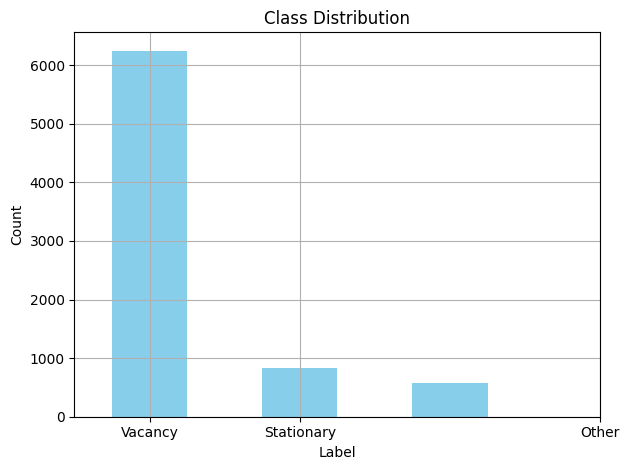


Cleaned Dataset Preview:
    Label  Temperature_F     PIR_1     PIR_2     PIR_3     PIR_4     PIR_5  \
0      0             86 -0.055875 -0.494950 -0.551045 -0.616061 -0.558023   
1      1             86 -0.055853 -0.180633 -0.333270 -0.513508 -0.663652   
2      0             86 -0.055861 -0.373279 -0.488606 -0.507475 -0.358319   
3      0             86 -0.055899 -0.995152 -1.059694 -0.671862 -0.219681   
4      0             86 -0.055863 -0.586203 -0.630236 -0.519540 -0.231234   

      PIR_6     PIR_7     PIR_8  ...    PIR_47    PIR_48    PIR_49    PIR_50  \
0 -0.230890  0.165129  0.450680  ... -0.577291 -0.614463 -0.574078 -0.572173   
1 -0.484048 -0.277654  0.084387  ... -0.660100 -0.654840 -0.554029 -0.425187   
2 -0.255089 -0.048284  0.160448  ... -0.566144 -0.612848 -0.552358 -0.484681   
3  0.072528  0.414444  0.640832  ... -0.456263 -0.574085 -0.761205 -0.654415   
4  0.035299  0.280811  0.264531  ... -0.481743 -0.276907 -0.445428 -0.629918   

     PIR_51    PIR_52    PIR_

In [2]:
# Step 1: Data Loading, Merging, Cleaning and Preprocessing

# Load datasets
df = pd.read_csv('pirvision_office_dataset1.csv')

# Combine 'Date' and 'Time' columns into a single 'DateTime' column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.drop(columns=['Date', 'Time'], inplace=True)

# Convert data types and clean
df['Label'] = df['Label'].astype(int)
df['Temperature_F'] = pd.to_numeric(df['Temperature_F'], errors='coerce')

# Drop rows with any missing values
df.dropna(inplace=True)

# Display dataset structure and statistics
print("\nDataset Shape:", df.shape)
print("\nColumn Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nStatistical Summary:\n", df.describe())

# Visualize class distribution
class_counts = df['Label'].value_counts()
class_counts.plot(kind='bar', color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 3], labels=["Vacancy", "Stationary", "Other"], rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# Normalize PIR sensor columns
pir_cols = [col for col in df.columns if col.startswith("PIR_")]
scaler = StandardScaler()
df[pir_cols] = scaler.fit_transform(df[pir_cols])

# Show preview of cleaned and normalized dataset
print("\nCleaned Dataset Preview:\n", df.head())
print("\nFinal Columns:\n", df.columns.tolist())


This substep performs a deeper analysis of the target class distribution. It summarizes the count and percentage of each class label (Vacancy, Stationary, Other) and calculates the class imbalance ratios. Understanding class imbalance is critical for selecting appropriate resampling strategies or performance metrics in classification tasks.

In [3]:
# Detailed Class Distribution Analysis

# Count instances of each label
label_counts = df['Label'].value_counts().sort_index()

# Map numerical labels to descriptive names
label_names = {0: 'Vacancy', 1: 'Stationary', 3: 'Other'}

# Create a summary DataFrame for class distribution
label_summary = pd.DataFrame({
    'Label': [label_names.get(i, f'Unknown ({i})') for i in label_counts.index],
    'Count': label_counts.values
})

# Calculate percentage representation of each class
label_summary['Percentage'] = (label_summary['Count'] / label_summary['Count'].sum()) * 100

# Compute imbalance ratios (Vacancy as reference)
imbalance_stationary = label_counts.get(0, 1) / label_counts.get(1, 1)
imbalance_other = label_counts.get(0, 1) / label_counts.get(3, 1)

# Display the summary and imbalance ratios
print("\n Activity Class Distribution Summary:\n")
print(label_summary.to_string(index=False))

print("\n Class Imbalance Ratios:")
print(f"Vacancy : Stationary  = {imbalance_stationary:.2f} : 1")
print(f"Vacancy : Other       = {imbalance_other:.2f} : 1")



 Activity Class Distribution Summary:

     Label  Count  Percentage
   Vacancy   6247   81.649458
Stationary    833   10.887466
     Other    571    7.463077

 Class Imbalance Ratios:
Vacancy : Stationary  = 7.50 : 1
Vacancy : Other       = 10.94 : 1


### Exploratory Data Visualization
This substep focuses on visualizing the PIR sensor signals, temperature, and activity label relationships. It helps uncover underlying data distributions, feature behaviors, inter-feature correlations, and time-based trends. These visual insights are critical for understanding the structure and dynamics of the data before model training.

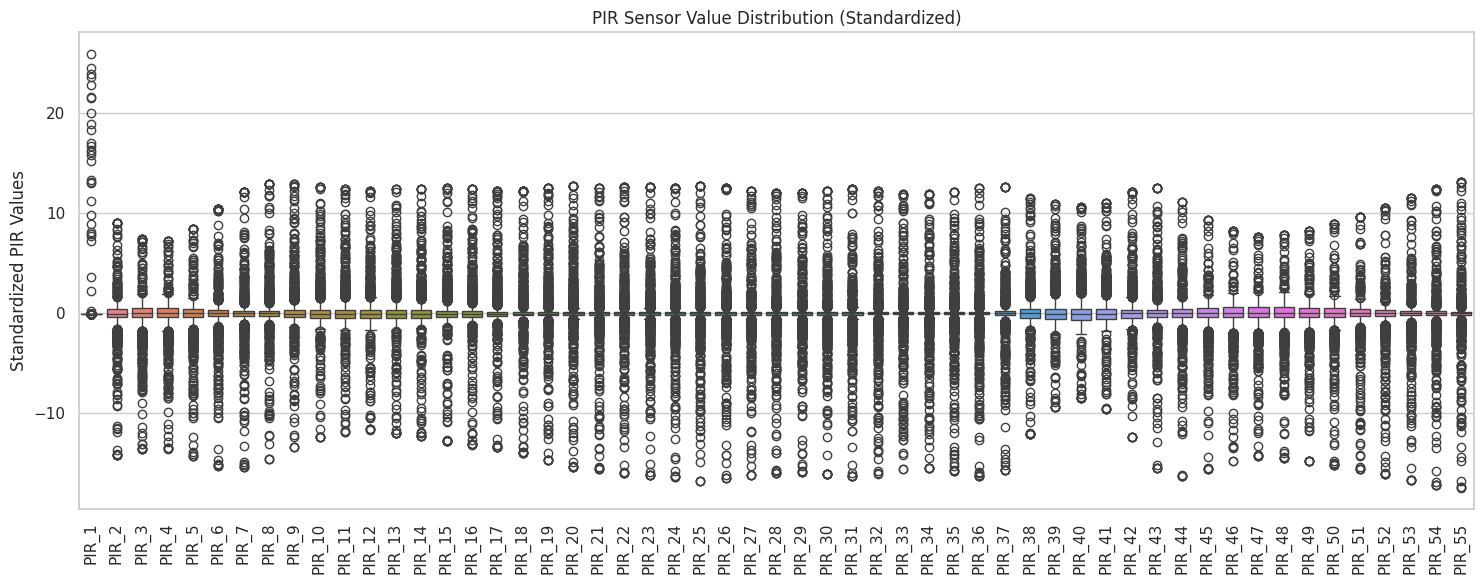

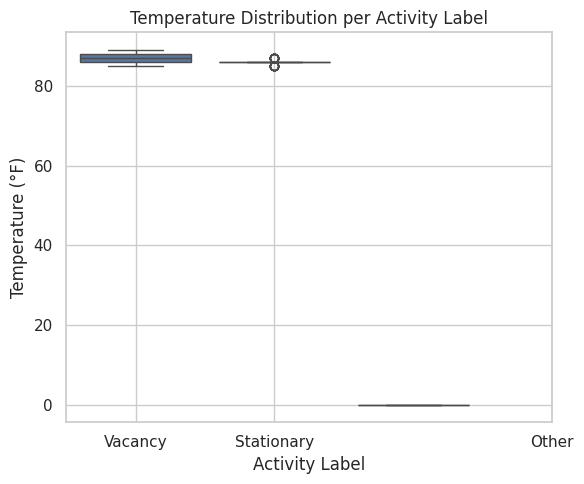

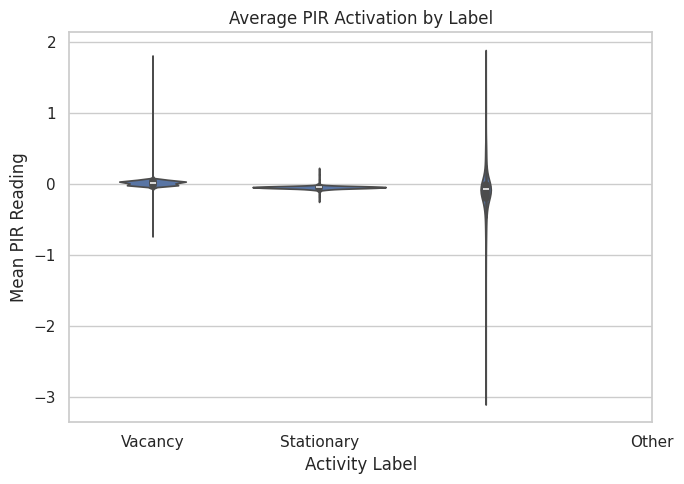

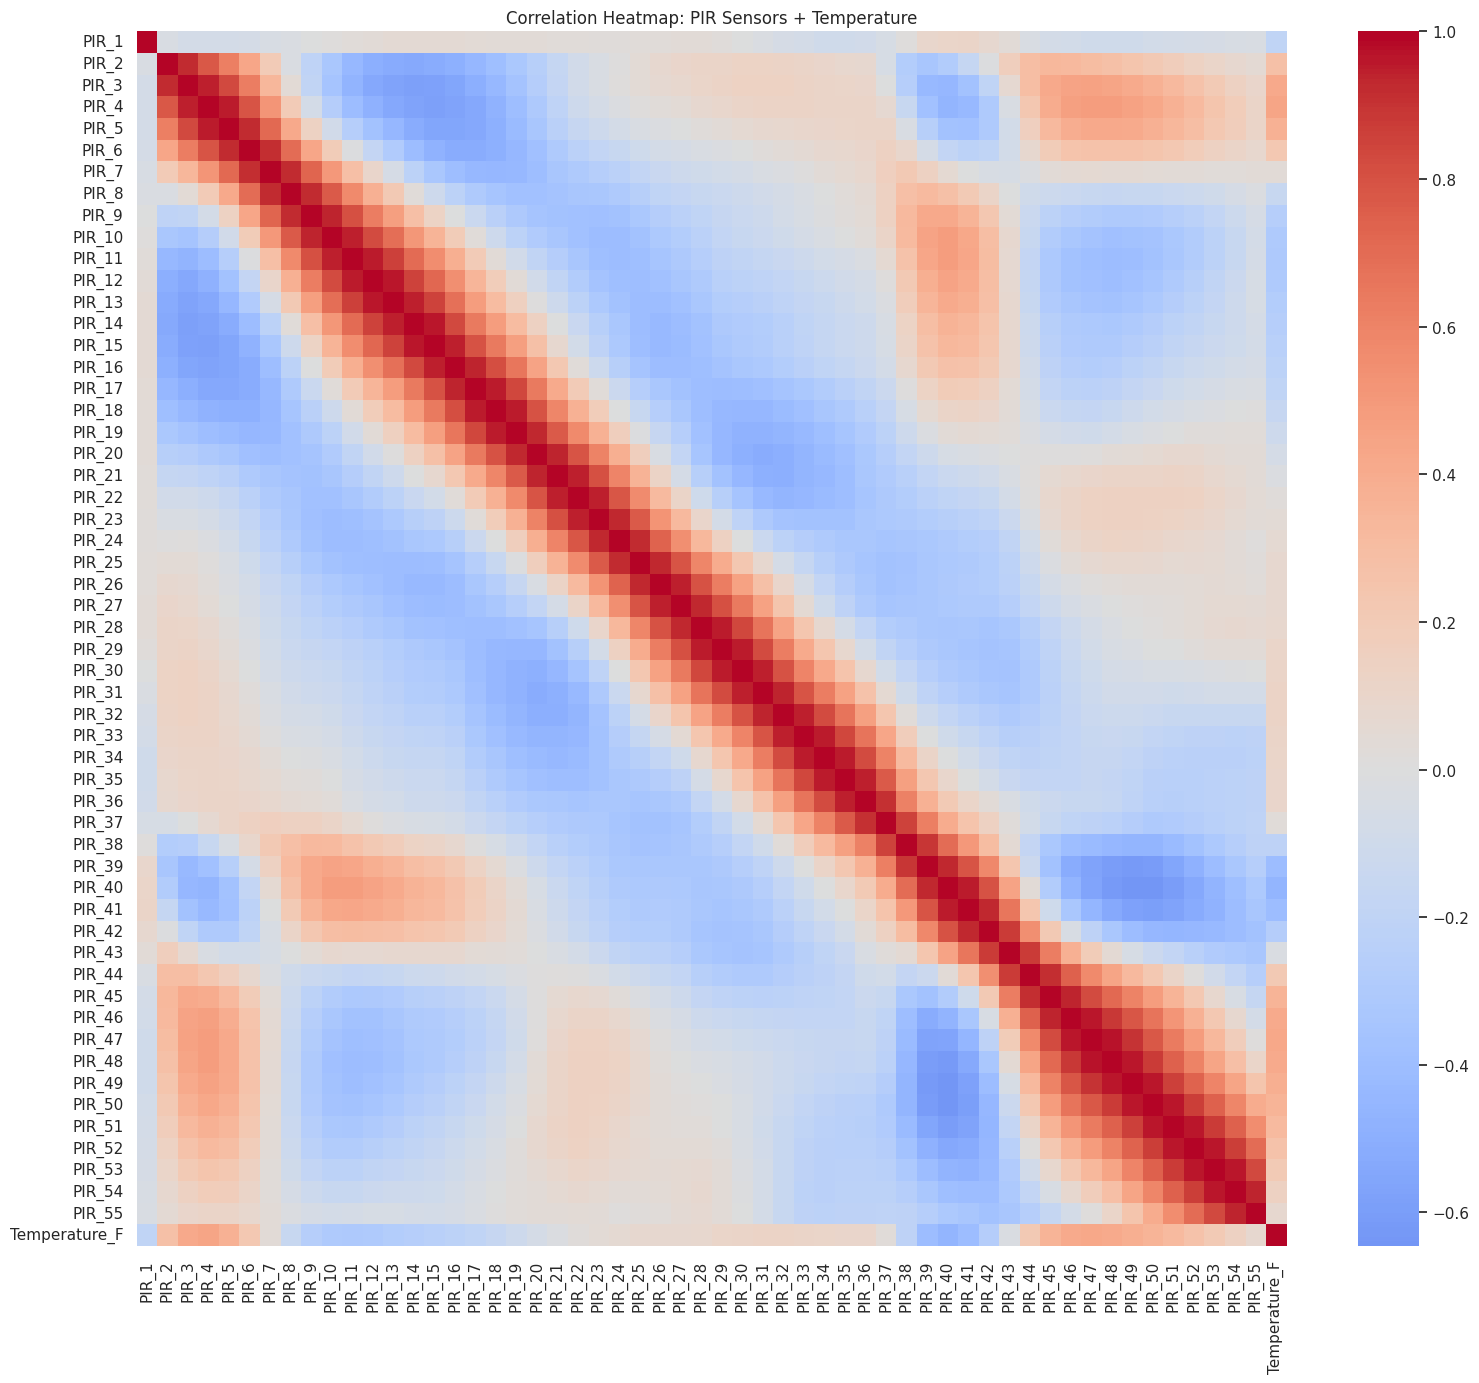

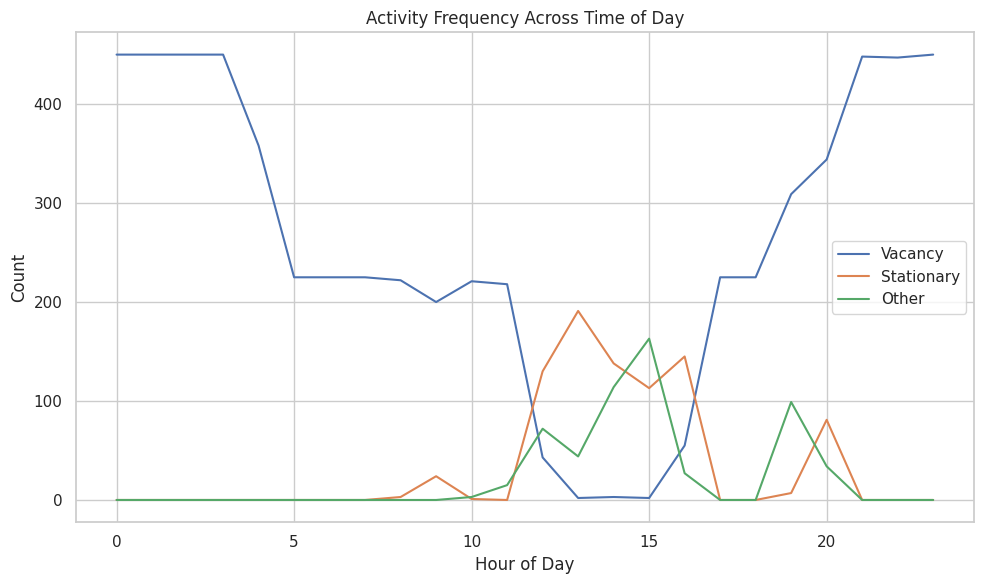

In [4]:
# Exploratory Data Visualization

# Set Seaborn plotting style
sns.set(style="whitegrid")

# 1. Distribution of PIR Sensor Values (Standardized)
plt.figure(figsize=(15, 6))
sns.boxplot(data=df[pir_cols])
plt.xticks(rotation=90)
plt.title('PIR Sensor Value Distribution (Standardized)')
plt.ylabel('Standardized PIR Values')
plt.tight_layout()
plt.show()

# 2. Ambient Temperature Distribution per Activity Label
plt.figure(figsize=(6, 5))
sns.boxplot(x='Label', y='Temperature_F', data=df)
plt.title('Temperature Distribution per Activity Label')
plt.xlabel('Activity Label')
plt.ylabel('Temperature (°F)')
plt.xticks(ticks=[0, 1, 3], labels=["Vacancy", "Stationary", "Other"])
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Violin Plot of Average PIR Sensor Activation per Activity Label
df['PIR_mean'] = df[pir_cols].mean(axis=1)

plt.figure(figsize=(7, 5))
sns.violinplot(x='Label', y='PIR_mean', data=df)
plt.title("Average PIR Activation by Label")
plt.xlabel("Activity Label")
plt.ylabel("Mean PIR Reading")
plt.xticks(ticks=[0, 1, 3], labels=["Vacancy", "Stationary", "Other"])
plt.tight_layout()
plt.show()

# 4. Correlation Heatmap: PIR Sensor Readings + Temperature
pir_temp_corr = df[pir_cols + ['Temperature_F']].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(pir_temp_corr, cmap='coolwarm', center=0, cbar=True)
plt.title("Correlation Heatmap: PIR Sensors + Temperature")
plt.tight_layout()
plt.show()

# 5. Activity Frequency Over Time (Hourly)
df['Hour'] = df['DateTime'].dt.hour
activity_by_hour = df.groupby(['Hour', 'Label']).size().unstack().fillna(0)

activity_by_hour.plot(kind='line', figsize=(10, 6))
plt.title("Activity Frequency Across Time of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.legend(["Vacancy", "Stationary", "Other"])
plt.grid(True)
plt.tight_layout()
plt.show()

# Clean-up temporary columns used for plotting
df.drop(columns=['PIR_mean', 'Hour'], inplace=True)


# Step 2: Modeling with PCA + Random Forest + GridSearchCV


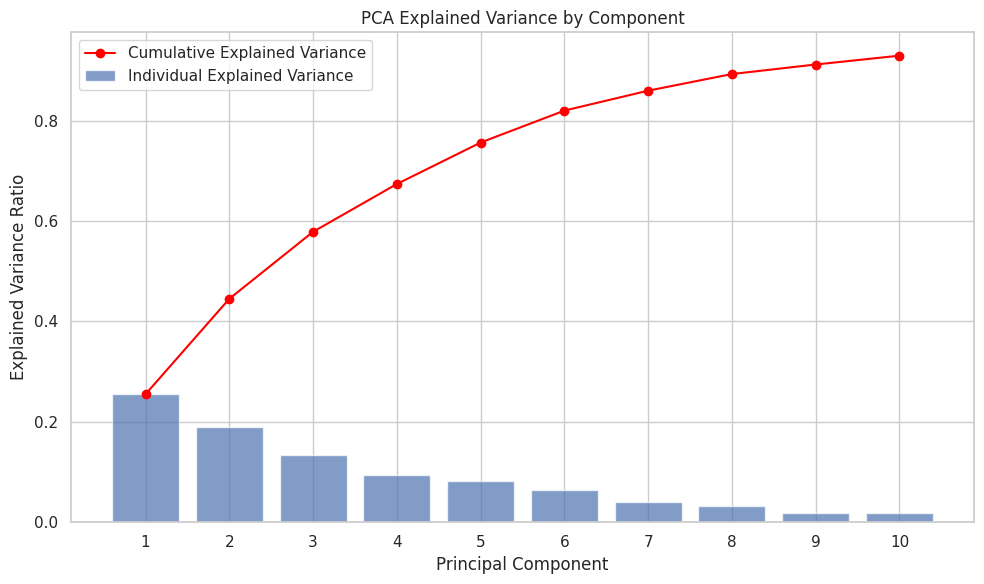

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters Found: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 100}
Test Accuracy: 0.9738903394255874

Confusion Matrix:
 [[625   1   0]
 [  1  77   5]
 [  0  13  44]]

Classification Report (Macro F1):
               precision    recall  f1-score   support

           0     0.9984    0.9984    0.9984       626
           1     0.8462    0.9277    0.8851        83
           3     0.8980    0.7719    0.8302        57

    accuracy                         0.9739       766
   macro avg     0.9142    0.8993    0.9045       766
weighted avg     0.9744    0.9739    0.9736       766



In [5]:
# Step 1: PCA Transformation (10 components)
pir_features = [col for col in df.columns if col.startswith("PIR_")]
pca = PCA(n_components=10)
pir_pca = pca.fit_transform(df[pir_features])

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot
plt.figure(figsize=(10,6))
plt.bar(range(1, 11), explained_variance, alpha=0.7, label='Individual Explained Variance')
plt.plot(range(1, 11), cumulative_variance, marker='o', color='red', label='Cumulative Explained Variance')
plt.title('PCA Explained Variance by Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, 11))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

pca_df = pd.DataFrame(pir_pca, columns=[f'PC{i+1}' for i in range(10)])
pca_df['Label'] = df['Label'].values

# Step 2: Train-test split (90/10)
X = pca_df.drop(columns='Label')
y = pca_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Step 3: Define Pipeline and Light Grid
pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid = {
    'clf__n_estimators': [100, 200],            # Single setting
    'clf__max_depth': [None, 10, 20],          # Small variation
    'clf__min_samples_leaf': [1, 2, 4],       # Small leaf size variation
}

# Step 4: GridSearchCV with 3-fold CV for speed
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Step 5: Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters Found:", grid_search.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report (Macro F1):\n", classification_report(y_test, y_pred, digits=4))



In [6]:

# Step 3: Train and Compare Multiple Classifiers

# Initialize models
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
svm_model = SVC(probability=True, random_state=42, class_weight='balanced')

# Train models
log_reg.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

# Generate predictions
y_pred_log = log_reg.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_rf = best_model.predict(X_test)

# Evaluation function
def eval_model(y_true, y_pred, name):
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

# Evaluate all models
eval_model(y_test, y_pred_log, "Logistic Regression")
eval_model(y_test, y_pred_svm, "Support Vector Machine (SVM)")
eval_model(y_test, y_pred_rf, "Random Forest")

# Feature importance from best tuned Random Forest (PC-level)
importances = best_model.named_steps['clf'].feature_importances_
print("\nFeature Importances from Random Forest:")
for i, val in enumerate(importances):
    print(f"PC{i+1}: {val:.4f}")




=== Logistic Regression ===
Accuracy: 0.8524804177545692
Confusion Matrix:
 [[556  70   0]
 [  0  76   7]
 [  5  31  21]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94       626
           1       0.43      0.92      0.58        83
           3       0.75      0.37      0.49        57

    accuracy                           0.85       766
   macro avg       0.72      0.72      0.67       766
weighted avg       0.91      0.85      0.87       766


=== Support Vector Machine (SVM) ===
Accuracy: 0.9516971279373369
Confusion Matrix:
 [[609  15   2]
 [  0  80   3]
 [  0  17  40]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       626
           1       0.71      0.96      0.82        83
           3       0.89      0.70      0.78        57

    accuracy                           0.95       766
   macro avg       0.87      0.88      0.86 

# Step 4: Outlier Detection on Class 3 ("Other Activity") Using PCA + Isolation Forest
This step identifies potential anomalies within the "Other activity" class, which is the most ambiguous in the dataset. Using PCA, the high-dimensional PIR sensor data is reduced to 2D for visualization. An Isolation Forest is then applied to detect outliers, helping to reveal irregular or noisy patterns in this complex class. This supports better understanding and potential refinement of class 3 in future analysis.

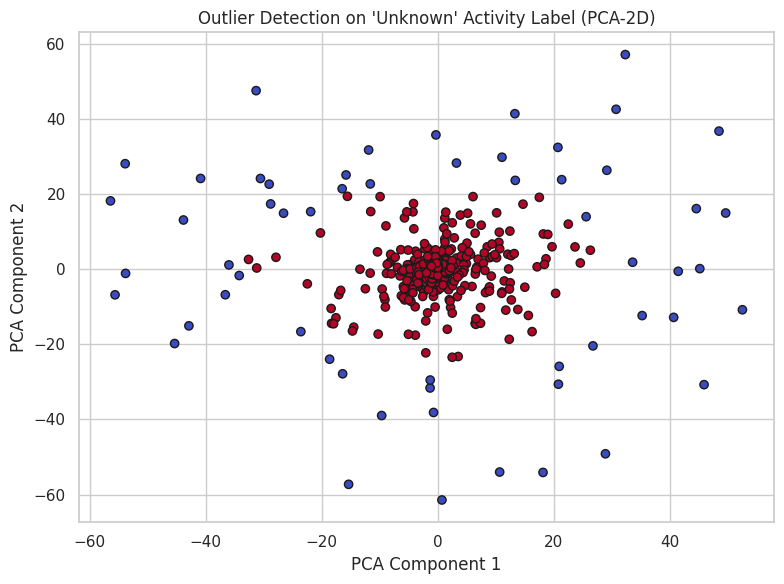


Outlier Detection Summary:
Outlier
 1    514
-1     57
Name: count, dtype: int64


In [7]:
# Step 4: Outlier Detection on 'Other Activity' (Label 3)

# 1. Filter rows with Label = 3 (Other activity/motion)
unknown_df = df[df['Label'] == 3]

# 2. Apply PCA to reduce PIR sensor data to 2 dimensions for visualization
unknown_pca = PCA(n_components=2).fit_transform(
    unknown_df[[col for col in df.columns if col.startswith("PIR_")]]
)

# 3. Use Isolation Forest to detect outliers (anomalies)
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outliers = iso_forest.fit_predict(unknown_pca)  # -1 = outlier, 1 = inlier

# 4. Add outlier results to the DataFrame
unknown_df = unknown_df.copy()
unknown_df['Outlier'] = outliers

# 5. Visualize the inliers vs outliers in 2D PCA space
plt.figure(figsize=(8, 6))
plt.scatter(
    unknown_pca[:, 0],
    unknown_pca[:, 1],
    c=unknown_df['Outlier'],
    cmap='coolwarm',
    edgecolor='k'
)
plt.title("Outlier Detection on 'Unknown' Activity Label (PCA-2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Summary of detected outliers
print("\nOutlier Detection Summary:")
print(unknown_df['Outlier'].value_counts())


# Step 5: Final Model Training After Outlier Removal
In this step, we are refining the modeling pipeline by removing outliers from the ambiguous class 3 ("Other Activity") using a combination of PCA (for dimensionality reduction) and Isolation Forest (for unsupervised anomaly detection). This targeted cleaning step helps eliminate noisy and inconsistent behavior patterns that could otherwise distort the classification process and affect model reliability.

After cleaning the dataset:
* PCA is re-applied to the cleaned PIR sensor readings, reducing them to 10 components.
* The cleaned data is then split into training and testing sets (80/20).
* Three classification models — Logistic Regression, Support Vector Machine (SVM), and Random Forest — are trained on the refined dataset.
* Each model’s performance is evaluated using precision, recall, and F1-score, allowing for an in-depth comparison of their effectiveness after outlier removal.

The best Random Forest parameters found through earlier tuning (n_estimators=100, max_depth=None, min_samples_leaf=1) were reused on the cleaned dataset. While these parameters remained effective, future work could include re-running hyperparameter optimization post outlier removal for improved performance tuning.

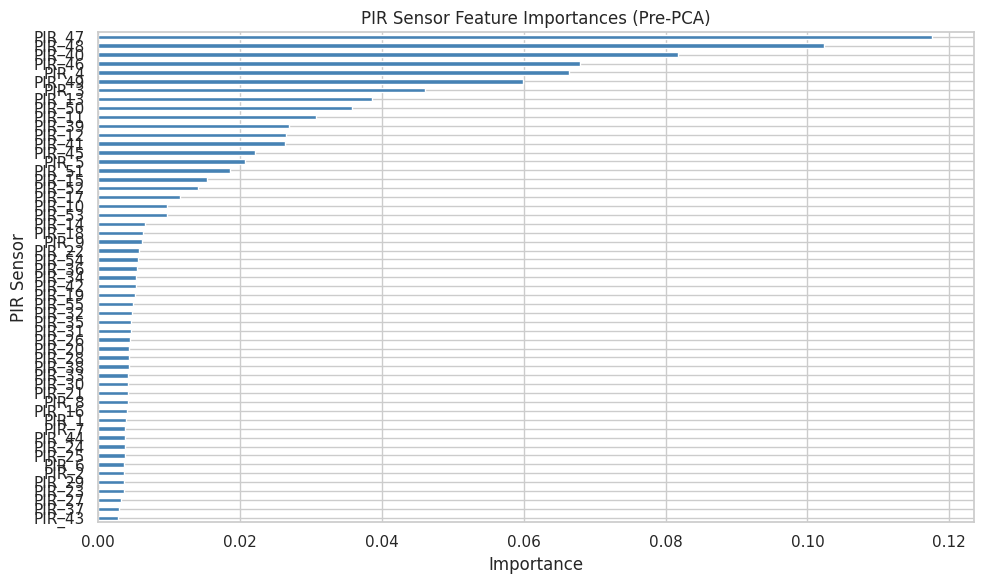


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1249
           1       0.52      0.94      0.67       167
           3       0.84      0.56      0.67       103

    accuracy                           0.89      1519
   macro avg       0.78      0.80      0.76      1519
weighted avg       0.93      0.89      0.90      1519


=== SVM ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1249
           1       0.80      0.98      0.88       167
           3       0.92      0.79      0.85       103

    accuracy                           0.97      1519
   macro avg       0.90      0.92      0.91      1519
weighted avg       0.97      0.97      0.97      1519


=== Random Forest (Best Params) ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1249
           1       0.87      0.93      0.90       

In [8]:

# -----------------------------------------------
# Step 1: Identify and Remove Outliers from Class 3 ("Other Activity")
# Select indices of all samples labeled as 3 (ambiguous activity)
label3_idx = df[df['Label'] == 3].index

# Apply PCA to reduce PIR sensor features to 2D for anomaly detection
pca_label3 = PCA(n_components=2).fit_transform(df.loc[label3_idx, pir_cols])

# Use Isolation Forest to detect outliers in the 2D PCA-transformed space
outlier_preds = IsolationForest(contamination=0.1, random_state=42).fit_predict(pca_label3)

# Create a clean dataset: all non-class-3 samples + inliers from class 3
clean_idx = df[df['Label'] != 3].index.union(label3_idx[outlier_preds == 1])
clean_df = df.loc[clean_idx]

# ----------------------------------------------------
# Step 1.1: Feature Importance of PIR Sensors (Pre-PCA)
# ----------------------------------------------------
# Extract PIR sensor data and corresponding labels
X_pir_clean = clean_df[[col for col in df.columns if col.startswith("PIR_")]]
y_pir_clean = clean_df['Label']

# Train a Random Forest on raw PIR features (no PCA yet)
pir_rf_clean = RandomForestClassifier(n_estimators=100, random_state=42)
pir_rf_clean.fit(X_pir_clean, y_pir_clean)

# Get feature importances
pir_feature_importances = pd.Series(pir_rf_clean.feature_importances_, index=X_pir_clean.columns)

# Sort and plot
plt.figure(figsize=(10, 6))
pir_feature_importances.sort_values(ascending=True).plot(kind='barh', color='steelblue')
plt.title("PIR Sensor Feature Importances (Pre-PCA)")
plt.xlabel("Importance")
plt.ylabel("PIR Sensor")
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------
# Step 2: Apply PCA on Cleaned Dataset
# Reapply PCA (10 components) to cleaned PIR sensor data
pca = PCA(n_components=10)
X_pca_rout = pca.fit_transform(clean_df[pir_cols])
y_rout = clean_df['Label'].values

# Split cleaned data into training and test sets (80/20 split)
X_train_rout, X_test_rout, y_train_rout, y_test_rout = train_test_split(
    X_pca_rout, y_rout, test_size=0.2, random_state=42, stratify=y_rout
)

# -----------------------------------------------
# Step 3: Define and Train Models Using Best RF Params
# Best Random Forest parameters obtained from previous GridSearchCV tuning
best_rf_params = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_leaf': 1
}

# Train Logistic Regression on cleaned dataset
log_clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced').fit(X_train_rout, y_train_rout)

# Train Support Vector Machine on cleaned dataset
svm_clf = SVC(probability=True, random_state=42, class_weight='balanced').fit(X_train_rout, y_train_rout)

# Train Random Forest using best parameters on cleaned dataset
rf_clf = RandomForestClassifier(**best_rf_params, random_state=42, class_weight='balanced').fit(X_train_rout, y_train_rout)

# -----------------------------------------------
# Step 4: Evaluate Model Performance on Test Set
# Loop through each model and print classification report
for model, name in zip(
    [log_clf, svm_clf, rf_clf],
    ['Logistic Regression', 'SVM', 'Random Forest (Best Params)']
):
    print(f"\n=== {name} ===")
    y_pred_rout = model.predict(X_test_rout)
    print(classification_report(y_test_rout, y_pred_rout))


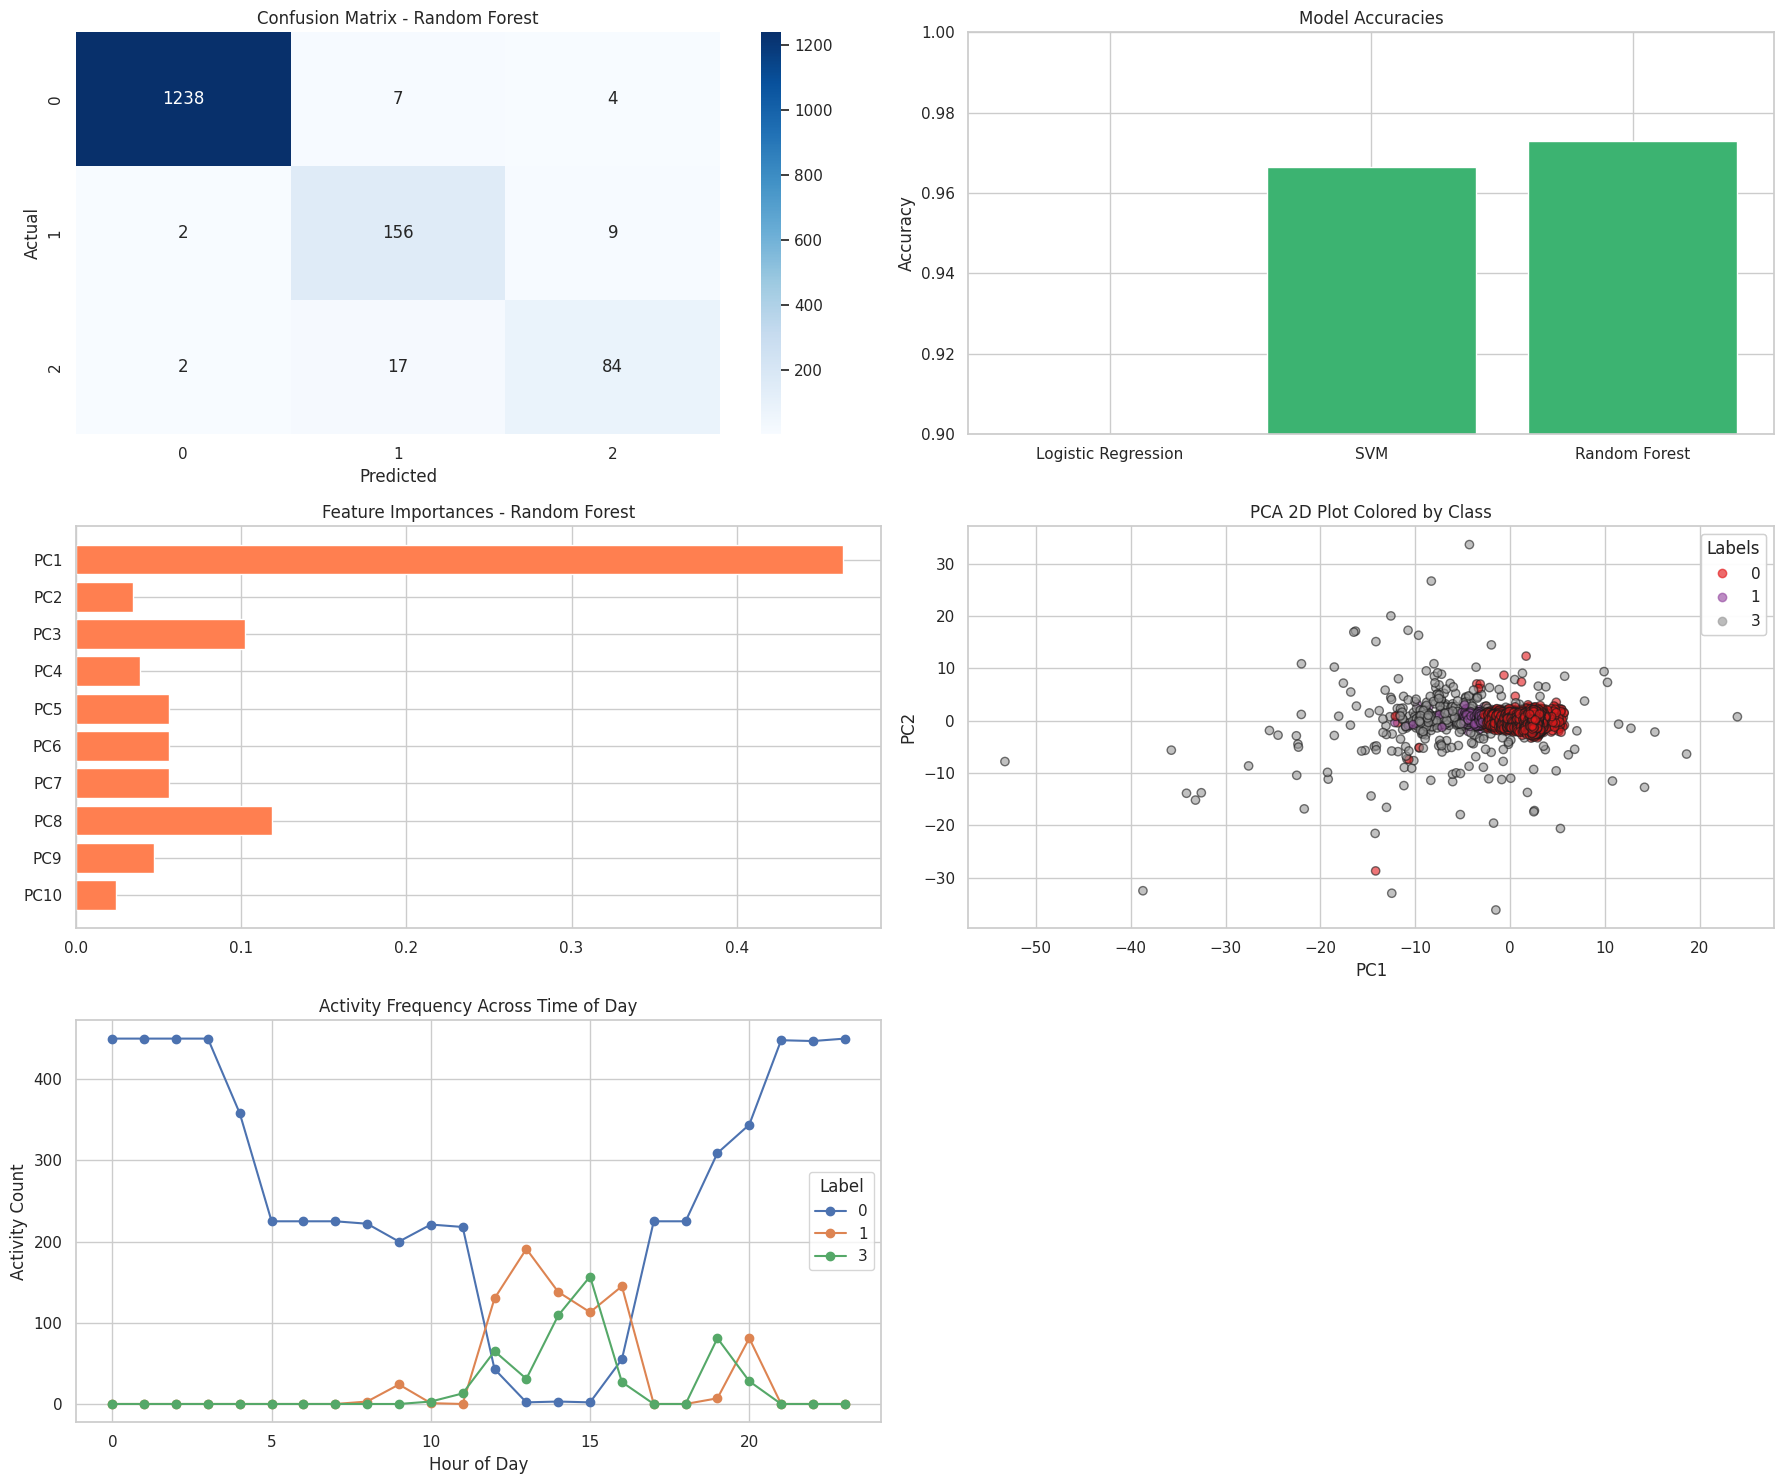

In [9]:
# ---------------------------------------------
# Step 5: Visualization of Final Model Performance and Cleaned Data Insights
# ---------------------------------------------
# This step visualizes:
# - Confusion Matrix (Random Forest)
# - Accuracy of all classifiers
# - Feature importances from Random Forest
# - PCA 2D plot colored by activity label
# - Hourly activity frequency plot

# Use cleaned PCA-transformed data and labels
X_clean = X_pca_rout  # Correct PCA-transformed cleaned feature set
y_clean = y_rout      # Correct cleaned label set

# Accuracy scores using models trained on cleaned data
accuracies = {
    'Logistic Regression': accuracy_score(y_test_rout, log_clf.predict(X_test_rout)),
    'SVM': accuracy_score(y_test_rout, svm_clf.predict(X_test_rout)),
    'Random Forest': accuracy_score(y_test_rout, rf_clf.predict(X_test_rout))
}

# Confusion Matrix for Random Forest
conf_rf = confusion_matrix(y_test_rout, rf_clf.predict(X_test_rout))

# Feature importances from Random Forest
feature_importances = rf_clf.feature_importances_
features = [f"PC{i+1}" for i in range(len(feature_importances))]

# 2D PCA projection for visualization
pca_2d = PCA(n_components=2).fit_transform(clean_df[pir_cols])

# Time-based activity distribution
df_time = clean_df.copy()
df_time['Hour'] = df_time['DateTime'].dt.hour
time_activity = df_time.groupby(['Hour', 'Label']).size().unstack().fillna(0)

# Create figure with 6 subplots
fig, axs = plt.subplots(3, 2, figsize=(18, 15))

# Panel 1: Confusion Matrix
sns.heatmap(conf_rf, annot=True, fmt='d', cmap='Blues', ax=axs[0, 0])
axs[0, 0].set_title("Confusion Matrix - Random Forest")
axs[0, 0].set_xlabel("Predicted")
axs[0, 0].set_ylabel("Actual")

# Panel 2: Accuracy Comparison
axs[0, 1].bar(accuracies.keys(), accuracies.values(), color='mediumseagreen')
axs[0, 1].set_title("Model Accuracies")
axs[0, 1].set_ylim([0.9, 1.0])
axs[0, 1].set_ylabel("Accuracy")

# Panel 3: Feature Importances from Random Forest
axs[1, 0].barh(features, feature_importances, color='coral')
axs[1, 0].set_title("Feature Importances - Random Forest")
axs[1, 0].invert_yaxis()

# Panel 4: PCA 2D Scatter Plot by Label
scatter = axs[1, 1].scatter(
    pca_2d[:, 0], pca_2d[:, 1], c=y_clean, cmap='Set1',
    alpha=0.6, edgecolor='k'
)
axs[1, 1].set_title("PCA 2D Plot Colored by Class")
axs[1, 1].set_xlabel("PC1")
axs[1, 1].set_ylabel("PC2")
legend1 = axs[1, 1].legend(*scatter.legend_elements(), title="Labels")
axs[1, 1].add_artist(legend1)

# Panel 5: Activity Frequency by Hour
time_activity.plot(kind='line', ax=axs[2, 0], marker='o')
axs[2, 0].set_title("Activity Frequency Across Time of Day")
axs[2, 0].set_xlabel("Hour of Day")
axs[2, 0].set_ylabel("Activity Count")
axs[2, 0].legend(title="Label")
axs[2, 0].grid(True)

# Panel 6: Left empty for layout symmetry
axs[2, 1].axis('off')

# Optimize layout
plt.tight_layout()
plt.show()


<ipython-input-10-3292fa9bfbbc>:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted, x='label', y='value', hue='model', palette='Set2', ci=None)


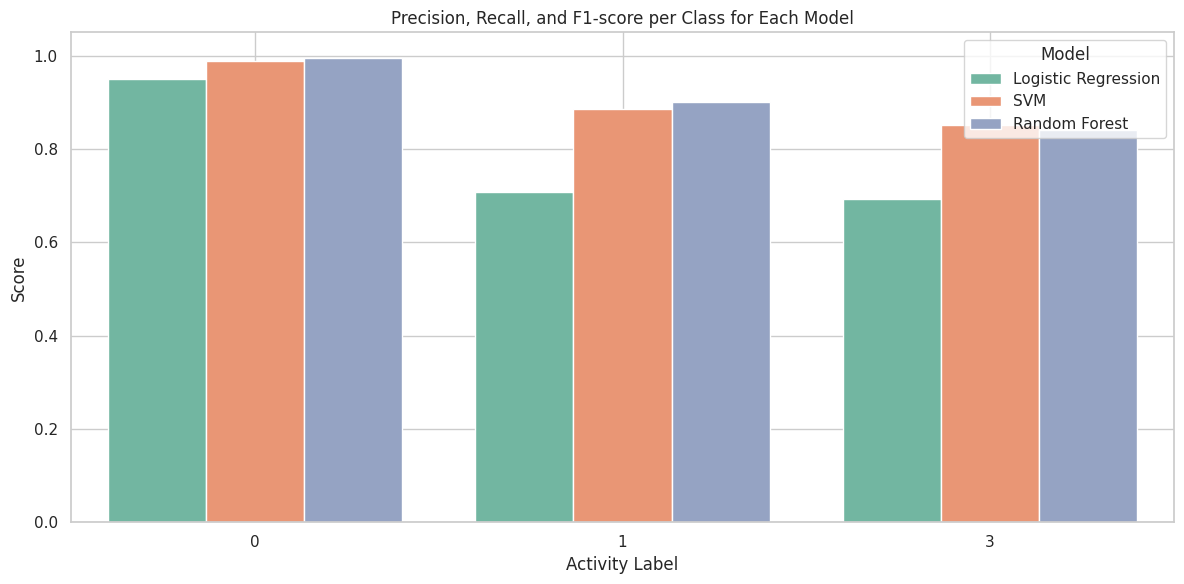

In [10]:
# --------------------------------------------------------
# Step 6: Class-Wise Precision, Recall, and F1-Score Comparison
# --------------------------------------------------------
# This step extracts class-wise performance metrics (precision, recall, f1-score)
# from all three classifiers, then visualizes them in a grouped bar chart.

# Helper function to extract metrics from classification_report
def get_metrics(clf, name):
    report = classification_report(y_test_rout, clf.predict(X_test_rout), output_dict=True)
    df = pd.DataFrame(report).T
    df = df[df.index.isin(['0', '1', '3'])]  # Keep only actual label rows
    df['model'] = name
    return df.reset_index().rename(columns={'index': 'label'})

# Generate metrics DataFrames for each classifier
df_log = get_metrics(log_clf, "Logistic Regression")
df_svm = get_metrics(svm_clf, "SVM")
df_rf = get_metrics(rf_clf, "Random Forest")

# Combine all into one DataFrame
metrics_df = pd.concat([df_log, df_svm, df_rf], ignore_index=True)

# Melt the DataFrame to long format for seaborn plotting
melted = metrics_df.melt(id_vars=['label', 'model'], value_vars=['precision', 'recall', 'f1-score'])

# Plot the metrics comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='label', y='value', hue='model', palette='Set2', ci=None)
plt.title("Precision, Recall, and F1-score per Class for Each Model")
plt.ylabel("Score")
plt.xlabel("Activity Label")
plt.ylim(0.0, 1.05)
plt.legend(title="Model")
plt.grid(True)
plt.tight_layout()
plt.show()


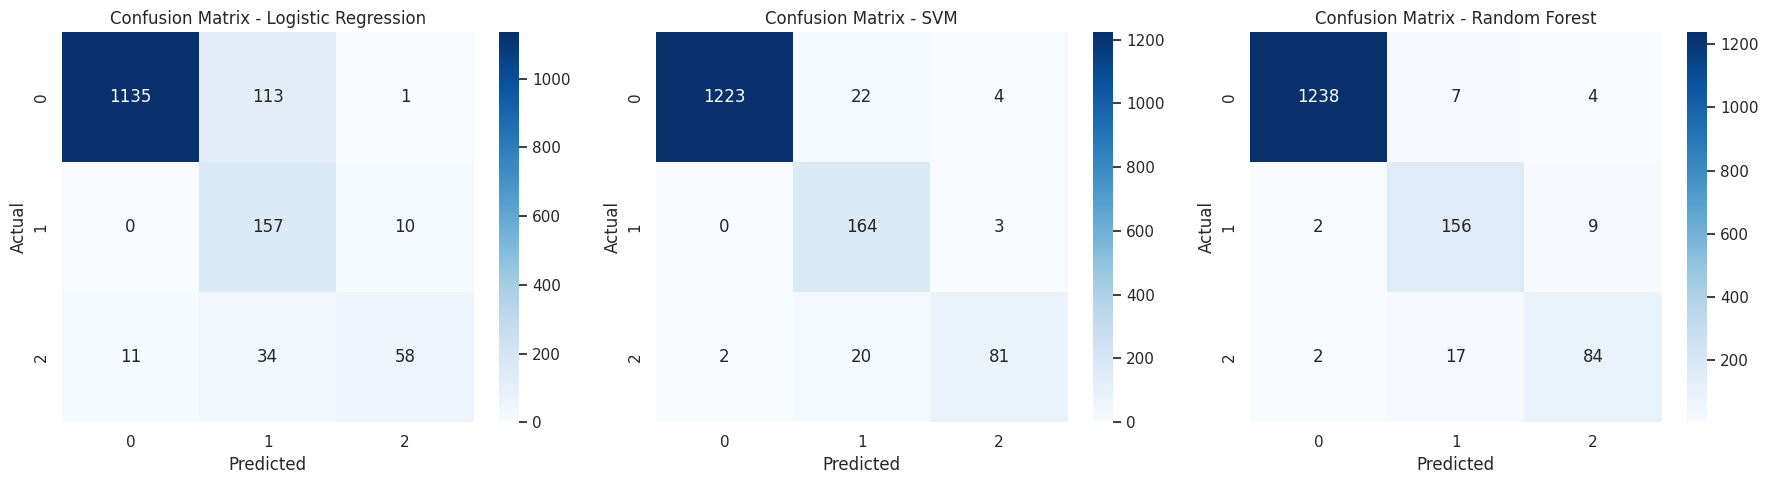

In [11]:
# --------------------------------------------------------
# Step 7: Side-by-Side Confusion Matrices for Final Models
# --------------------------------------------------------
# This step compares classification errors between models using confusion matrices.
# It highlights how well each classifier distinguishes between classes 0, 1, and 3.

# Generate confusion matrices using the cleaned test set
cm_log = confusion_matrix(y_test_rout, log_clf.predict(X_test_rout))
cm_svm = confusion_matrix(y_test_rout, svm_clf.predict(X_test_rout))
cm_rf = confusion_matrix(y_test_rout, rf_clf.predict(X_test_rout))

# Set up subplot layout (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Create side-by-side confusion matrix heatmaps
for ax, cm, title in zip(
    axes,
    [cm_log, cm_svm, cm_rf],
    ["Logistic Regression", "SVM", "Random Forest"]
):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"Confusion Matrix - {title}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Improve layout spacing
plt.tight_layout()
plt.show()


In [12]:
import joblib
from IPython.display import FileLink

# Save the final trained Random Forest model
model_filename = "rf_pirvision_model.joblib"
joblib.dump(rf_clf, model_filename)

# Provide download link for the model
print(f"Model saved successfully as '{model_filename}'. Click the link below to download:")
FileLink(model_filename)


Model saved successfully as 'rf_pirvision_model.joblib'. Click the link below to download:


/content/rf_pirvision_model.joblib